> **注**：调查数据集项目

# 项目：探索与电影票房相关的各类因素

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介

> **项目背景**：本数据集中包含 1 万条电影信息，信息来源为“电影数据库”（TMDb，The Movie Database），包括用户评分和票房。“演职人员 (cast)”、“电影类别 (genres)”等数据列包含由竖线字符（|）分隔的多个数值。“演职人员 (cast) ”列中有一些奇怪的字符。先不要清洁它们，你可以保持原样，不去管它们。以“_adj”结尾的最后两列表示了考虑了通货膨胀之后的相关电影的预算和收入（以2010年美元的价值来计算）。

> **提出问题**：你应该在你的调查里分析至少一个因变量和三个自变量。每年最受欢迎的电影类别是哪些？票房高的电影有哪些特点？预算，人员（演员、导演）、类别、上映月份，与净利润的关系
1，预算与净利润之间有什么关系？
2，针对净利润一项，平均利润最高的5位的演员是谁？
3，针对净利润一项，平均利润最高的5电影类别是哪些？
4，针对净利润一项，平均利润最高的5个上映月份是哪几个月？


In [159]:
# 用这个框对你计划使用的所有数据包进行设置
#   导入语句。
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


<a id='wrangling'></a>
## 数据整理

> **提示**：针对数据中多余的列进行删除，并填充数据中缺失的数据，去除重复数据，并将cast、genres两列的数据拆分和重组，计算和添加新列


In [160]:
# 加载数据并打印几行,来检查数据
#   类型，以及是否有缺失数据或错误数据的情况。
df = pd.read_csv('tmdb-movies.csv')
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


In [161]:
df.columns #查看含有的列标签

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

### 删除问题中不涉及探索的列，新增列以便计算，进行数据清洗和重新排列

In [162]:
df = df.drop(['id','imdb_id','budget','revenue','popularity','homepage','tagline','overview'],axis=1)

In [163]:
df['profit'] = df['revenue_adj'] - df['budget_adj'] #新增利润一列 profit

In [164]:
df.head(2)

,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
0,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09
1,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,future|chase|post-apocalyptic|dystopia|australia,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08,2.101614e+08


In [165]:
df = df.fillna('0')#去除Nan值，并用0填充

In [166]:
df = df.query('profit != 0') # 仅留下净利润profit不为0的行,该部分数据才有商业分析意义
df.shape

(6161, 14)

In [167]:
#将df的column_name列中的元素，按照“|”进行拆分，并合成为新的df
def split_columns(df,column_name):
    df_new = df[column_name].str.split('|', expand=True).stack().reset_index(level=1, drop=True).rename(column_name)
    return df.drop(column_name, axis=1).join(df_new)

In [168]:
#将df的genres列中的元素，按照“|”进行拆分，并合成为新的df
df_genres = split_columns(df,'genres')
df_genres.shape

(15963, 14)

In [169]:
#将df的genres列中的元素，按照“|”进行拆分，并合成为新的df
df_cast = split_columns(df,'cast')
df_cast.shape

(30535, 14)

In [170]:
df['month']=df['release_date'].apply(lambda x: x.split('/')[0]) #提取上映月份，并放入新列month中

In [171]:
df.drop_duplicates(inplace = True)#去除重复行
df_cast.drop_duplicates(inplace = True)
df_genres.drop_duplicates(inplace = True)

In [172]:
#提取预算项不为0的dataframe
df_bgt = df.copy()
df_bgt = df_bgt.query('budget_adj != 0')
df_bgt.shape

(5165, 15)

In [173]:
#提取演员表不为0的dataframe
df_cast_profit = df_cast.copy()
df_cast_profit = df_cast_profit.query('cast != 0')
df_cast_profit.shape

(30525, 14)

In [174]:
#提取类型不为0的dataframe，便于之后计算电影类型与利润的关系
df_genres_profit = df_genres.copy()
df_genres_profit = df_genres_profit.query('genres != 0')
df_genres_profit.shape

(15958, 14)

In [175]:
#copy原df为df_month_profit，并提取月份不为0的dataframe便于之后计算月份与利润的关系
df_month_profit = df.copy()
df_month_profit = df_month_profit.query('month !=0')
df_month_profit.shape

(6160, 15)

<a id='eda'></a>
## 探索性数据分析


### 研究问题 1, 预算与净利润之间有什么关系？（预算与净利润之间的关系比较，散点图，计算相关性）

In [176]:
df_bgt.head(2)

,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,month
0,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09,6
1,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,future|chase|post-apocalyptic|dystopia|australia,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08,2.101614e+08,5


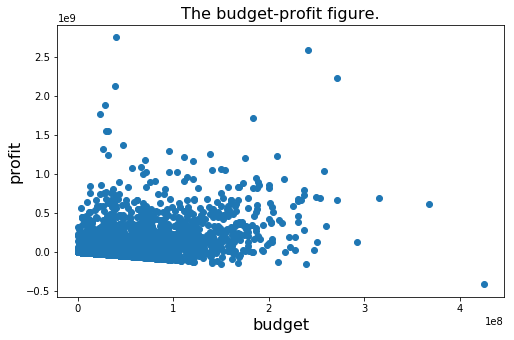

In [177]:
# 用这个代码框和其它代码框探索数据。请务必记得添加
#   Markdown 框，以便记录你的观察和调查结果。
plt.figure(figsize=(8,5))
plt.scatter(df_bgt['budget_adj'],df_bgt['profit'])
plt.title('The budget-profit figure.',fontsize=16)
plt.xlabel('budget',fontsize=16)
plt.ylabel('profit',fontsize=16);

In [178]:
np.corrcoef(df_bgt['budget_adj'],df_bgt['profit'])[0,1]  #计算相关系数，结果为0.42，呈正相关，且相关水平为中等

0.42483078095712756

### 研究问题 2，针对净利润一项，平均利润最高的5位的演员是谁？ 

In [179]:
# 请继续探索数据，解决你额外的研究问题。
#   如果有其它问题要调查，
#   请根据需要添加更多标题。
df_cast_profit.head(2)

,original_title,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,cast
0,Jurassic World,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09,Chris Pratt
0,Jurassic World,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09,Bryce Dallas Howard


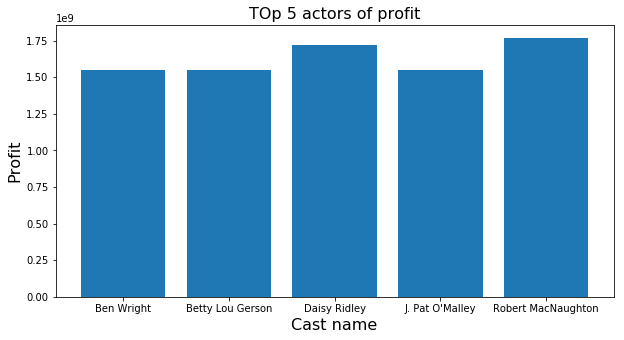

In [180]:
df_cast_profit_mean = df_cast_profit.groupby('cast')['profit'].mean()
top5_cast = df_cast_profit_mean.sort_values(ascending=False)[:5]
plt.figure(figsize=(10,5)) #查询《Python编程》从入门到实践，p302
plt.bar(top5_cast.index,top5_cast.values);
plt.xlabel('Cast name',fontsize = 16)
plt.ylabel('Profit',fontsize = 16)
plt.title('TOp 5 actors of profit',fontsize = 16);

In [181]:
top5_cast

cast
Robert MacNaughton    1.767968e+09
Daisy Ridley          1.718723e+09
J. Pat O'Malley       1.545635e+09
Betty Lou Gerson      1.545635e+09
Ben Wright            1.545635e+09
Name: profit, dtype: float64

### 研究问题 3，针对净利润一项，平均利润最高的5电影类别是哪些？

In [182]:
df_genres_profit.head(2)

,original_title,cast,director,keywords,runtime,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,genres
0,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09,Action
0,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09,Adventure


genres
Adventure          1.437724e+08
Animation          1.415966e+08
Family             1.225214e+08
Fantasy            1.179847e+08
Science Fiction    9.194157e+07
Name: profit, dtype: float64

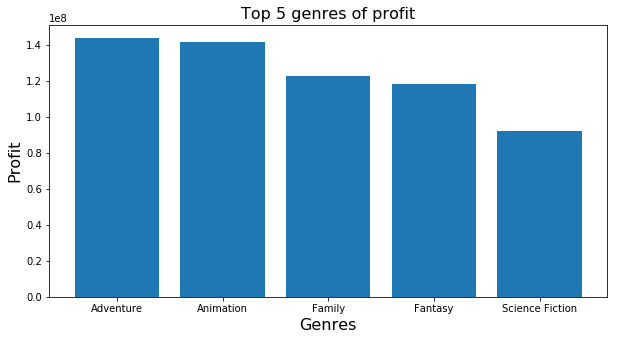

In [183]:
df_genres_profit_mean = df_genres_profit.groupby('genres')['profit'].mean()
top5_genres = df_genres_profit_mean.sort_values(ascending=False)[:5]
plt.figure(figsize=(10,5)) #查询《Python编程》从入门到实践，p302
plt.bar(top5_genres.index,top5_genres.values);
plt.xlabel('Genres',fontsize = 16)
plt.ylabel('Profit',fontsize = 16)
plt.title('Top 5 genres of profit',fontsize = 16);
top5_genres### 研究问题 4，针对净利润一项，平均利润最高的5个上映月份是哪几个月？

### 研究问题 4，针对净利润一项，平均利润最高的5个上映月份是哪几个月？

In [184]:
df_month_profit.head(2)

,original_title,cast,director,keywords,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit,month
0,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,monster|dna|tyrannosaurus rex|velociraptor|island,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,1.254446e+09,6
1,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,future|chase|post-apocalyptic|dystopia|australia,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08,2.101614e+08,5


month
6     1.196782e+08
12    9.779938e+07
11    9.072959e+07
5     8.945936e+07
7     8.419288e+07
Name: profit, dtype: float64

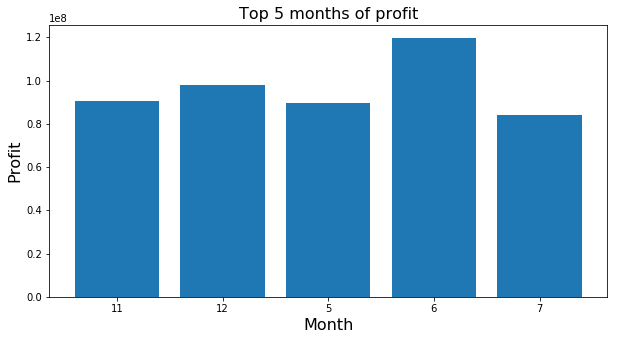

In [130]:
df_month_profit_mean = df_month_profit.groupby('month')['profit'].mean()
plt.figure(figsize=(10,5))
df_top5_month = df_month_profit_mean.sort_values(ascending=False)[:5]
plt.bar(df_top5_month.index,df_top5_month.values);
plt.xlabel('Month',fontsize = 16)
plt.ylabel('Profit',fontsize = 16)
plt.title('Top 5 months of profit',fontsize = 16);
df_top5_month

<a id='conclusions'></a>
## 结论

> 1，净利润与预算之间呈正相关关系，皮尔逊相关系数为0.42，为中等相关关系，并非很强的线性关系，对于预算高的电影，会有相对较高的利润预期。

> 2，以电影平均的净利润值为标准，获得净利润最高的前5位演员分别是：Robert MacNaughton、Daisy Ridley、Betty Lou Gerson、J. Pat O'Malley、Martha Wentworth

> 3，以电影平均的净利润值为标准，获得净利润最高的前5类电影分别是：Animation、Adventure、Family 、Fantasy、Science Fiction

> 4，以电影平均的净利润值为标准，获得净利润最高的前5个月份分别是：6月、12月、5月、11月、7月

In [202]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

255